# Подключение библиотек и необходимые функции

In [297]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import math

In [299]:
def make_plot(func, func_name, x, y, true_solution, found_solution = np.array([])):

    x = np.linspace(-x, x, 200)
    y = np.linspace(-y, y, 200)

    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    x_opt, y_opt, z_opt = true_solution 

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='inferno', alpha=0.15, edgecolor='none')


    if found_solution.any():
        for point in found_solution:
            x_found, y_found, z_found = point
            ax.scatter(x_found, y_found, z_found, color='deeppink', s=100, 
                       label=f'Found Global Optimum ({x_found}, {y_found}, {round(z_found, 3)})')
            
    ax.scatter(x_opt, y_opt, z_opt, color='black', s=100, 
               label=f'Analytical Global Optimum ({x_opt}, {y_opt}, {round(z_opt, 3)})')
    
    ax.set_title(f"{func_name}", fontsize=14)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.legend()

    plt.show()

# Аналитические решения

In [302]:
matyas_function = lambda x, y: 0.26 * (x**2 + y**2) - 0.48 * x * y

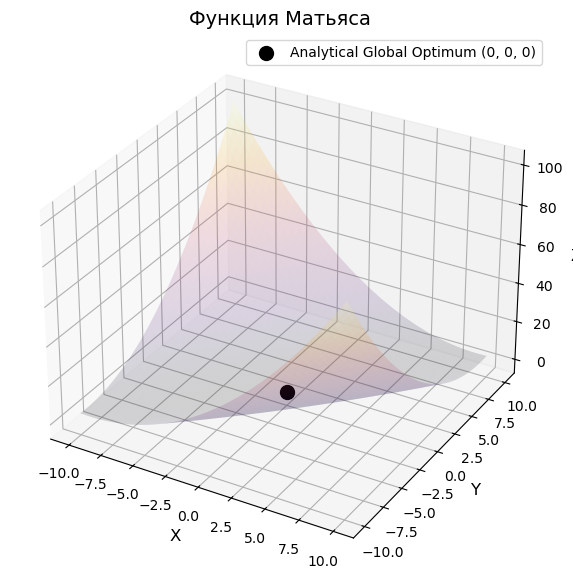

In [304]:
matyas_opt_global = np.array([0,0,0])
make_plot(matyas_function, "Функция Матьяса" , 10, 10, matyas_opt_global)

In [306]:
def levi_function(x, y):
    z =(np.sin(np.pi * x)**2 + (x - 1)**2 * (1 + np.sin(3 * np.pi * y)**2) +
             (y - 1)**2 * (1 + np.sin(2 * np.pi * y)**2))
    return z

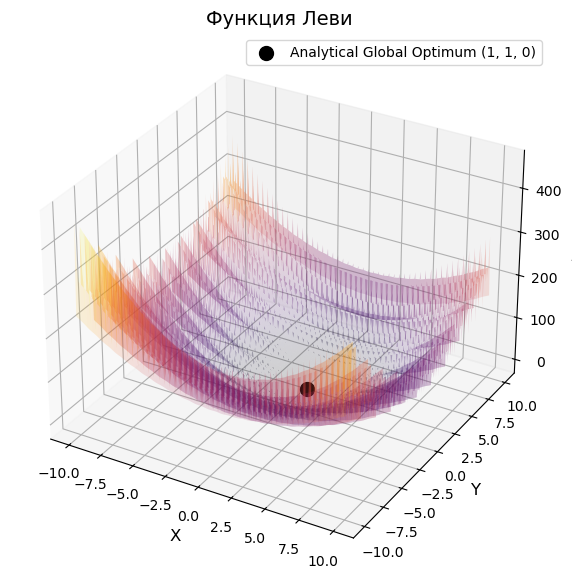

In [308]:
levi_opt_global = np.array([1,1,0])
make_plot(levi_function, "Функция Леви" , 10, 10, levi_opt_global)

# Реализация градиентного метода

## Градиент функции Матьяса

In [312]:
def matyas_grad(point):
    
    x = point[0]
    y = point[1]
    
    df_dx = 0.52*x - 0.48*y
    df_dy = 0.52*y - 0.48*y
    
    return df_dx, df_dy

## Градиент функции Леви

In [315]:
def levi_grad(point):
    
    x = point[0]
    y = point[1]
    
    df_dx = (6*np.pi * np.sin(3*np.pi*x) * np.cos(3*np.pi*x) +
                2*(x-1)*(1+(np.sin(3*np.pi*y))**2))
    df_dy = (6*np.pi*((x-1)**2)*np.sin(3*np.pi*y)*np.cos(3*np.pi*y) + 
                2*(y-1)*(1+(sin(2*np.pi*y))**2) + 4*np.pi*((y-1)**2)*np.sin(2*np.pi*y)*np.cos(2*np.pi*y)
               )
    return df_dx, df_dy

# Реализация подсчета ошибки

In [318]:
def mean_error_calculation(function, gradient, GDS_type, analytical_optimum, start_points):
    
    
    learning_rate = 0.001
    max_iter = 100000
    
    found_points = []
    errors = []
    analytical_optimum = np.array(analytical_optimum, dtype = "float128")
    
    if GDS_type == "standard": 
    
        for point in start_points: 

            point = gradient_descent(gradient, point, learning_rate, max_iter)

            point = np.append(point, function(point[0],point[1]))
            found_points.append(point)
            error = np.linalg.norm(analytical_optimum - point)
            errors.append(error)
            
    elif GDS_type == "nesterov":
        
        beta = 0.9
        
        velocity = np.array([0,0])
        
        for point in start_points: 

            point = nesterov_momentum(gradient, point, beta, learning_rate, max_iter)

            point = np.append(point, function(point[0],point[1]))
            found_points.append(point)
            error = np.linalg.norm(analytical_optimum - point)
            errors.append(error)
        
    elif GDS_type == "ADAM":
        
        beta1 = 0.9
        beta2 = 0.99
        eps = 1e-8
        velocity = np.array([0,0])
        G = np.array([0,0])
    
        for point in start_points: 

            point = adaptive_momentum(gradient, point, beta1, beta2, eps, learning_rate, max_iter)

            point = np.append(point, function(point[0],point[1]))
            found_points.append(point)
            error = np.linalg.norm(analytical_optimum - point)
            errors.append(error)
            
    elif GDS_type == "nesterov_scheduled":
        
        beta = 0.9
        lr_initial = 0.1
        iters_drop = 10
        drop = 0.5
        
        velocity = np.array([0,0])
        
        for point in start_points: 

            point = nesterov_momentum_scheduled(gradient, point, beta ,lr_initial, iters_drop, drop, max_iter)
                
            point = np.append(point, function(point[0],point[1]))
            found_points.append(point)
            error = np.linalg.norm(analytical_optimum - point)
            errors.append(error)
 
    average_error = np.mean(errors)

    return found_points, average_error

## Градиентный спуск

In [321]:
def gradient_descent(gradient, point, learning_rate, max_iter): 
    
    point = np.array(point, dtype = "float128")
    
    for i in range(max_iter):
        
        gradient_in_point = np.array(gradient(point), dtype = "float128")        
        point -= learning_rate * gradient_in_point 
        
    return point    

In [323]:
matyas_start_points = [[10,10], [-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]]
matyas_pts, err = mean_error_calculation(matyas_function, matyas_grad, "standard", 
                                           matyas_opt_global, matyas_start_points)
matyas_pts = np.array(matyas_pts)
err

0.1147013650656820778

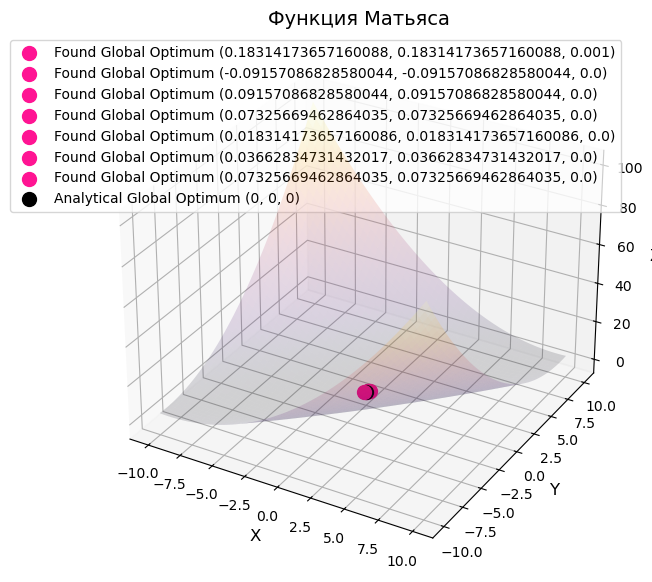

In [325]:
make_plot(matyas_function, "Функция Матьяса" , 10, 10, matyas_opt_global, matyas_pts)

In [326]:
levi_start_points = [[-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]] 
levi_pts, error = mean_error_calculation(levi_function, levi_grad, "standard",
                                       levi_opt_global, levi_start_points)
levi_pts = np.array(levi_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 21.667436512650543


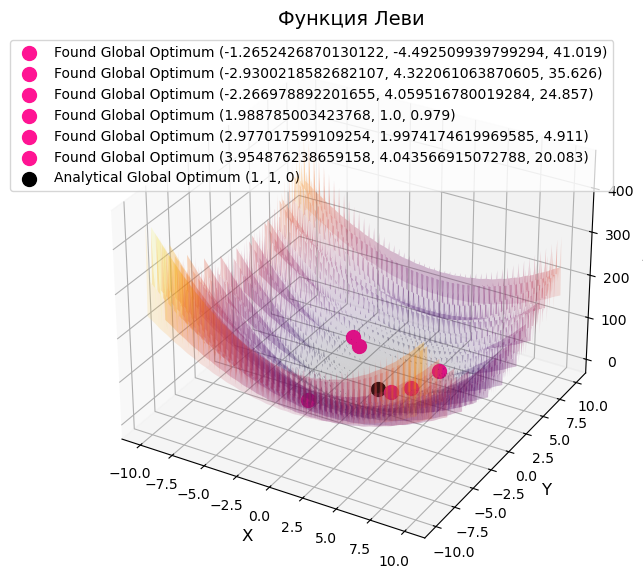

In [328]:
make_plot(levi_function, "Функция Леви" , 10, 10, levi_opt_global, levi_pts)

# Реализация моментной модификации Нестерова

In [330]:
def nesterov_momentum(gradient, point, beta ,learning_rate, max_iter):
    
    point = np.array(point, dtype = "float128")
    
    velocity = np.array([0,0])
    
    for i in range(max_iter):
        
        bv = beta*velocity 
        next_point = point + bv 
        gradient_in_next_point = np.array(gradient(next_point), dtype = "float128") 
        velocity = beta * velocity - learning_rate*gradient_in_next_point
        point = point+velocity
        
    return point

In [331]:
nesterov_momentum(matyas_grad, [5,5], 0.9, 0.001, 100000)

array([1.85598595e-17, 1.85598595e-17], dtype=float128)

In [332]:
matyas_start_points = [[10,10], [-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]]
matyas_pts, error = mean_error_calculation(matyas_function, matyas_grad, "nesterov", 
                                           matyas_opt_global, matyas_start_points)
matyas_pts = np.array(matyas_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 2.3247878717237718e-17


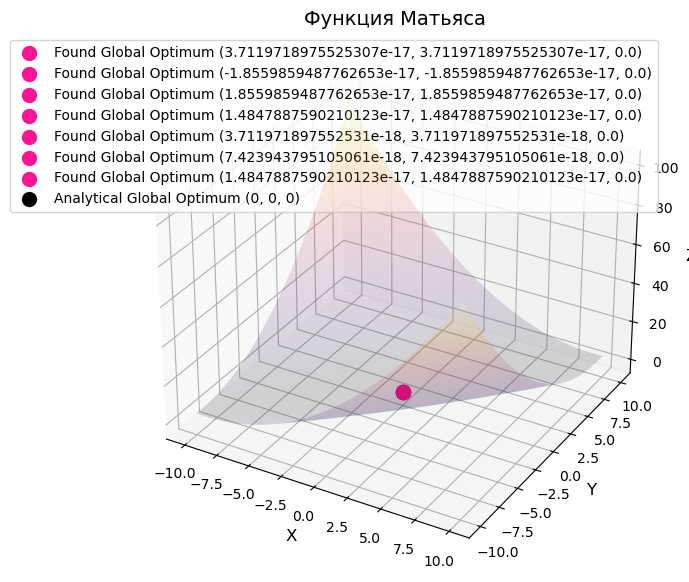

In [333]:
make_plot(matyas_function, "Функция Матьяса" , 10, 10, matyas_opt_global, matyas_pts)

In [334]:
levi_start_points = [[-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]] 
levi_pts, error = mean_error_calculation(levi_function, levi_grad, "nesterov", 
                                       levi_opt_global, levi_start_points)
levi_pts = np.array(levi_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 8.308194199821903


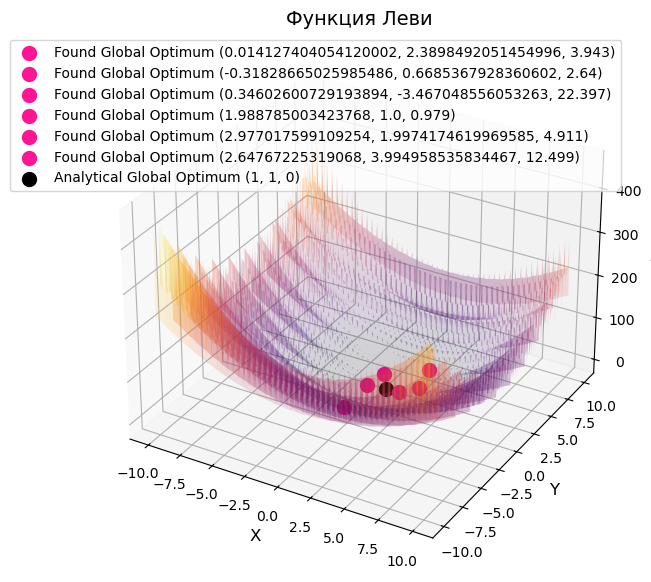

In [335]:
make_plot(levi_function, "Функция Леви" , 10, 10, levi_opt_global, levi_pts)

# Реализация ADAM

In [337]:
def adaptive_momentum(gradient, point, beta1, beta2, eps, learning_rate, max_iter):
    
    point = np.array(point, dtype = "float128")
    
    velocity = np.array([0,0])
    G = np.array([0,0])
    
    for i in range(max_iter):
        gradient_in_point = np.array(gradient(point), dtype = "float128") 
        velocity = beta1 * velocity + (1-beta1)*gradient_in_point
        G = beta2 * G + (1-beta2)*(gradient_in_point)**2
        point = point - (learning_rate*velocity)/np.sqrt(G+eps)
        
    return point

In [338]:
matyas_start_points = [[10,10], [-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]]
matyas_pts, error = mean_error_calculation(matyas_function, matyas_grad, "ADAM", 
                                           matyas_opt_global, matyas_start_points)
matyas_pts = np.array(matyas_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 0.0


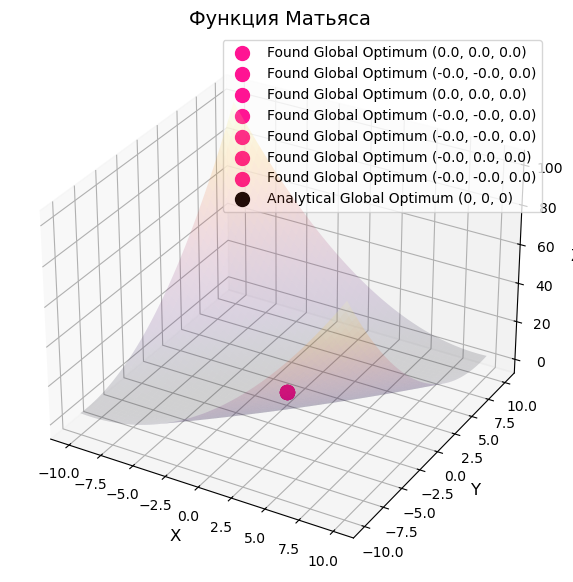

In [339]:
make_plot(matyas_function, "Функция Матьяса" , 10, 10, matyas_opt_global, matyas_pts)

In [340]:
levi_start_points = [[-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]] 
levi_pts, error = mean_error_calculation(levi_function, levi_grad, "ADAM", 
                                       levi_opt_global, levi_start_points)
levi_pts = np.array(levi_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 24.5288625779721


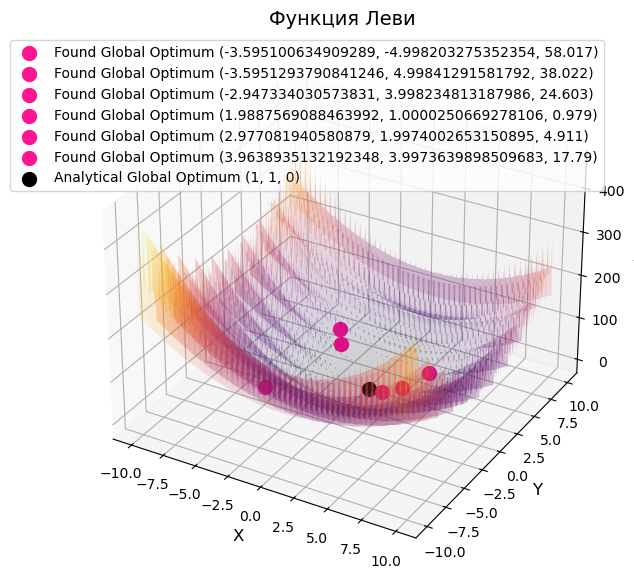

In [341]:
make_plot(levi_function, "Функция Леви" , 10, 10, levi_opt_global, levi_pts)

# Реализация  Step Decay в купе с методом Нестерова


In [343]:
def nesterov_momentum_scheduled(gradient, point, beta ,lr_initial, iters_drop, drop, max_iter):
    
    point = np.array(point, dtype = "float128")
    
    velocity = np.array([0,0])
    
    learning_rate = lr_initial
    
    for i in range(max_iter):
        
        if (i + 1) % iters_drop == 0 : 
            learning_rate = lr_initial * math.pow(drop, math.floor((1+i)/iters_drop))
        
        bv = beta*velocity 
        next_point = point + bv 
        gradient_in_next_point = np.array(gradient(next_point), dtype = "float128") 
        velocity = beta * velocity - learning_rate*gradient_in_next_point
        point = point+velocity
        
    return point

In [344]:
matyas_start_points = [[10,10], [-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]]
matyas_pts, error = mean_error_calculation(matyas_function, matyas_grad, "nesterov_scheduled", 
                                           matyas_opt_global, matyas_start_points)
matyas_pts = np.array(matyas_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 2.4392989996805006


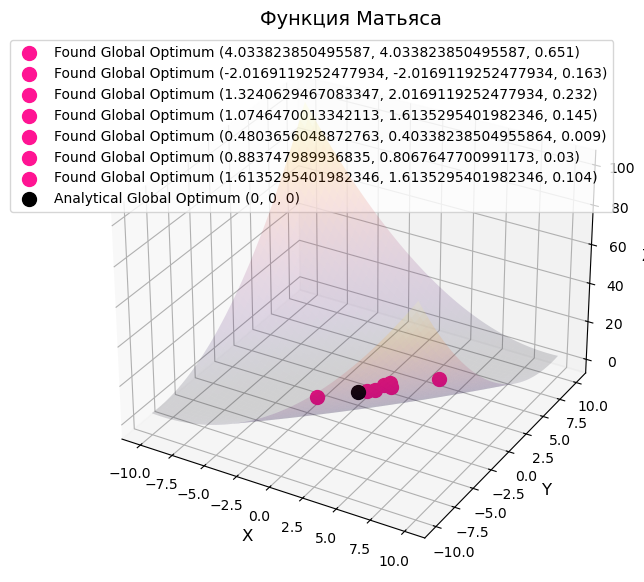

In [345]:
make_plot(matyas_function, "Функция Матьяса" , 10, 10, matyas_opt_global, matyas_pts)

In [346]:
levi_start_points = [[-5,-5], [-4,5], [-3,4], [2,1], [3,2], [4,4]] 
levi_pts, error = mean_error_calculation(levi_function, levi_grad, "ADAM", 
                                       levi_opt_global, levi_start_points)
levi_pts = np.array(levi_pts)
print(f"Усредненная ошибка: {error}")

Усредненная ошибка: 24.5288625779721


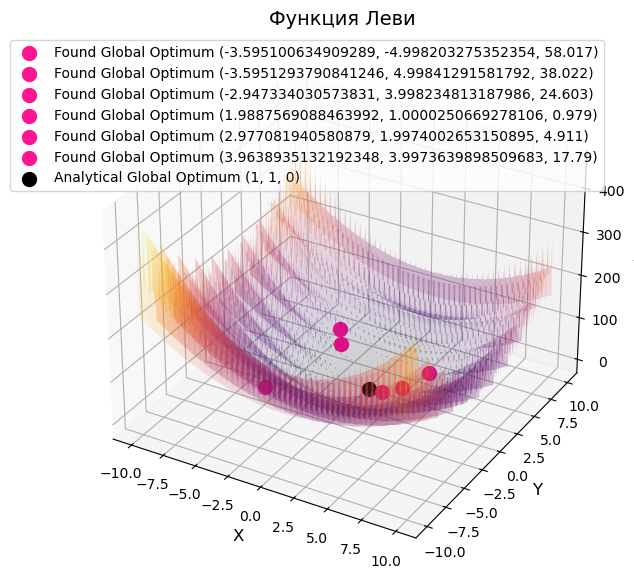

In [347]:
make_plot(levi_function, "Функция Леви" , 10, 10, levi_opt_global, levi_pts)

# Символьное дифференцирование

In [349]:
from sympy import *

In [350]:
x = symbols('x')
y = symbols('y')

In [351]:
def matyas_grad_symbol(point):
    f = '0.26 * (x**2 + y**2) - 0.48 * x * y'
    return diff(f, x).subs(x, point[0]).subs(y, point[1]), diff(f, y).subs(x, point[0]).subs(y, point[1])

In [352]:
matyas_grad([2,2])

(0.08000000000000007, 0.08000000000000007)

In [353]:
matyas_grad_symbol([2,2])

(0.0800000000000001, 0.0800000000000001)

In [354]:
def levi_grad_symbol(point):
    f = sin(pi * x)**2 + (x - 1)**2 * (1 + sin(3 * pi * y)**2) + (y - 1)**2 * (1 + sin(2 * pi * y)**2)
    return diff(f, x).subs(x, point[0]).subs(y, point[1]), diff(f, y).subs(x, point[0]).subs(y, point[1]), 


In [355]:
levi_grad([2,2])

(1.9999999999999862, 1.99999999999998)

In [356]:
levi_grad_symbol([2,2])

(2, 2)

# Численная аппроксимация дифференцирования

In [358]:
def num_diff(func, x, y, h=1e-9):
    
    df_dx = (func(x + h, y) - func(x - h, y)) / (2 * h)
    df_dy = (func(x, y + h) - func(x, y - h)) / (2 * h)
    
    return df_dx, df_dy

In [359]:
num_diff(matyas_function, 2,2)

(0.08000000661922968, 0.08000000661922968)

In [360]:
num_diff(levi_function, 2,2)

(2.000000165480742, 2.000000165480742)

# Выводы

На основе данной работы можно сделать следующие выводы: 
1) На малоразмерной функции градиентный спуск в вариации Нестерова показывает себя лучше, чем ADAM; 
2) Проведена реализация стандартного метода градиентного спуска;
3) Проведена моментная реализация метода градиентного спуска;
4) Проведена адаптивная реализация метода градиентного спуска;
5) Также реализована вариация с изменяющимся во времени шагом обучения;
6) Произведено символьное дифференцирование с помощью библиотеки sympy;
7) Произведено численное интегрерование функции;
8) Проведен сравнительный анализ для представленных градиентных спусков и методов дифференцирования.